In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# config
numEpochs = 4 # number of epochs to train the GPT+PT model
embeddingSize=512 # the hidden dimension of the representation of both GPT and PT
numPoints=30 # number of points that we are going to receive to make a prediction about f given x and y, if you don't know then use the maximum
numVars=1 # the dimenstion of input points x, if you don't know then use the maximum
numYs=1 # the dimension of output points y = f(x), if you don't know then use the maximum
blockSize = 100 # spatial extent of the model for its context
batchSize = 128
dataDir = 'D:/Datasets/Symbolic Dataset/Datasets'
dataInfo = 'XYE_{}Var_{}Points'.format(numVars, numPoints)
target = 'Skeleton' #'EQ'
dataFolder = '1Var_RandSupport_FixedLength_0to3_3.1to6_30Points'
addr = './SavedModels/bestModel/' # where to save model
maxNumFiles = 30

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars, target='EQ'):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
        self.target = target
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        
        try:
            chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        except:
            print("Couldn't convert to json: {}".format(chunk))
            
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk[self.target]+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            if lines[-1]==-1:
                lines = lines[:-1]
            text += lines #json.loads(line)       
            
    return text

In [7]:
path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
text = text[:-1] if len(text[-1]) == 0 else text
train_dataset = CharDataset(text, blockSize, chars, target=target) 

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]


data has 110000 examples, 48 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([21, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  5, 45, 11,  6, 23,  4,  4,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32])
id:15795
inputs:<sqrt(abs(C*x1+C))__________________________________________________________________________________
outputs:sqrt(abs(C*x1+C))>__________________________________________________________________________________
points:tensor([[2.4200, 2.0300, 2.4200, 2.5400, 1.8100, 2.5700, 2.0800, 2.8300, 1.1300,
         2.2100, 0.1500, 2.4700, 1.6400, 0.6500, 1.2200, 2.2300, 1.0300, 0.6800,
         0.0500, 1.9300, 1.1100, 0.0300, 0.8400, 1.5600, 0.5800, 2.4700, 2.0900,
         0.6300, 0.3000, 0.9000],
        [1.4100, 1.2700, 1.4100, 1

In [9]:
path = '{}/{}/Val/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textVal = processDataFiles([files[0]])
textVal = textVal.split('\n') # convert the raw text to a set of examples
val_dataset = CharDataset(textVal, blockSize, chars, target=target)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

data has 1001 examples, 48 unique.


In [10]:
idx = np.random.randint(val_dataset.__len__())
inputs, outputs, points = val_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(0.0100) tensor(2.9300)
id:860
inputs:<2*C**2*x1**2+4*C**2*x1+2*C**2______________________________________________________________________
outputs:2*C**2*x1**2+4*C**2*x1+2*C**2>______________________________________________________________________
points:tensor([[2.1200, 0.4300, 2.3800, 2.5600, 1.1000, 2.9300, 2.0300, 2.4400, 2.0600,
         0.7400, 0.8800, 2.2200, 2.1000, 1.7400, 0.9600, 0.3500, 2.1700, 0.0800,
         0.6100, 1.2000, 2.5700, 2.5200, 2.1300, 1.6800, 2.6100, 0.0300, 1.4400,
         1.9100, 1.4600, 1.8400],
        [0.5200, 0.1100, 0.5800, 0.6300, 0.2800, 0.7100, 0.5000, 0.6000, 0.5100,
         0.1900, 0.2200, 0.5500, 0.5200, 0.4300, 0.2400, 0.0900, 0.5300, 0.0200,
         0.1600, 0.3000, 0.6300, 0.6200, 0.5300, 0.4200, 0.6400, 0.0100, 0.3600,
         0.4700, 0.3700, 0.4600]])


In [11]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles(files)
textTest = textTest.split('\n') # convert the raw text to a set of examples
# test_dataset_target = CharDataset(textTest, blockSize, chars, target=target)
test_dataset = CharDataset(textTest, blockSize, chars)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.66it/s]

data has 1001 examples, 48 unique.


In [12]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(0.0100) tensor(2.9900)
id:270
inputs:<sqrt(abs(x1-0.7))-sin(0.45*x1)_____________________________________________________________________
outputs:sqrt(abs(x1-0.7))-sin(0.45*x1)>_____________________________________________________________________
points:tensor([[2.8100, 1.7600, 2.3700, 2.5400, 0.0800, 2.3900, 0.5900, 1.9900, 1.1100,
         1.1700, 1.9500, 2.5100, 2.0300, 2.1300, 0.8900, 1.7700, 0.0600, 1.7600,
         2.6100, 1.6700, 2.6800, 2.7600, 0.3600, 0.0800, 1.8400, 0.8400, 1.0400,
         2.9900, 1.6700, 1.8000],
        [0.5000, 0.3200, 0.4200, 0.4500, 0.7500, 0.4200, 0.0600, 0.3600, 0.1600,
         0.1900, 0.3500, 0.4400, 0.3600, 0.3800, 0.0500, 0.3200, 0.7700, 0.3200,
         0.4600, 0.3000, 0.4700, 0.4900, 0.4200, 0.7500, 0.3300, 0.0100, 0.1400,
         0.5400, 0.3000, 0.3300]])


In [13]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/24/2021 01:27:42 - INFO - mingpt.model -   number of parameters: 3.057972e+07


In [14]:
fName = '{}_SymbolicGPT_{}_{}_{}_MINIMIZE.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [15]:
from mingpt.trainer import Trainer, TrainerConfig
import os

try: 
    os.mkdir(addr)
except:
    print('Folder already exists!')
    
ckptPath = '{}/{}.pt'.format(addr,fName.split('.txt')[0])
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=numEpochs, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path=ckptPath)
trainer = Trainer(model, train_dataset, val_dataset, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Folder already exists!


epoch 1 iter 124: train loss 0.55323. lr 5.922953e-04:  15%|███▋                     | 125/860 [01:00<05:43,  2.14it/s]

Input:tensor([21, 23,  5, 45, 11,  5, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  5, 45,
        11,  6, 23,  4,  4,  6, 23,  5, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,
         5, 45, 11,  6, 23,  4,  4, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([43,  5, 45, 11,  6, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  4, 45, 11,
         6, 23,  4,  4,  6, 23,  4, 23, 41, 42, 44,  3, 33, 34, 43,  3, 23,  4,
        43, 11,  6, 23,  4,  4, 22,  4,  6,  4, 43,  4, 23,  5, 43, 41, 43, 43,
        23,  4, 43, 23, 42,  4, 43, 22, 43, 41, 42, 44,  3, 42, 34, 43,  3, 23,
        43, 43, 11,  6, 23,  4,  4,  3, 43, 43, 42, 42, 42, 42, 43, 43, 43, 43,
        43, 33, 43, 42, 42, 42, 43, 43, 43, 43], device='cuda:0')
Input:<C*x1*sqrt(abs(C*x1+C))+C*sqrt(abs(C*x1+C))_______

epoch 1 iter 393: train loss 0.87695. lr 5.257303e-04:  46%|███████████▍             | 394/860 [03:08<03:43,  2.09it/s]

Input:tensor([21, 43, 36, 39,  3, 43, 36, 39,  3, 23,  5, 45, 11,  6, 23,  4,  4, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([43, 36, 39,  3, 23, 36, 39,  3, 23,  5, 45, 11,  6, 23,  4,  4, 22,  5,
        43,  5, 39,  4,  3,  5, 12, 23, 23,  5, 45, 22, 22, 42,  5, 22, 22, 23,
        22, 36,  5, 36,  5, 11, 22, 22, 22,  5, 22,  5, 13,  5, 22, 22, 22, 23,
         4,  5, 45, 23, 45,  5, 11, 22, 36, 22, 42, 44,  3, 33, 34, 43,  3, 23,
         5, 45, 11,  6, 23,  4,  4, 22, 22, 22, 22, 22, 22, 22, 45, 22, 22, 22,
        22, 22, 22, 45, 22, 22, 22, 22, 45, 22], device='cuda:0')
Input:<sin(sin(C*x1+C))_________________________________

epoch 1 iter 859: train loss 0.12962. lr 3.002194e-04: 100%|█████████████████████████| 860/860 [06:58<00:00,  2.06it/s]
05/24/2021 01:34:44 - INFO - mingpt.trainer -   test loss: 0.142916
05/24/2021 01:34:44 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_1Var_30Points_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 2 iter 859: train loss 0.06891. lr 6.000000e-05: 100%|█████████████████████████| 860/860 [06:59<00:00,  2.05it/s]
05/24/2021 01:41:46 - INFO - mingpt.trainer -   test loss: 0.085704
05/24/2021 01:41:46 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_1Var_30Points_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 3 iter 807: train loss 0.08400. lr 2.720793e-04:  94%|███████████████████████▍ | 807/860 [06:33<00:25,  2.07it/s]

Input:tensor([21, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  5, 45, 11,  6, 23,  4,  4,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  5, 45, 11,  6, 23,  4,  4, 22,
        43,  4, 43,  4, 22,  5, 43,  4, 23,  5, 22, 43, 22, 33,  5, 43,  3, 23,
        22, 45, 23, 43, 45, 11, 11, 22, 45,  4, 22,  5, 23,  5,  3, 39, 39, 23,
         4,  5,  6, 23, 45,  5, 39, 22, 43, 22, 42, 44,  3, 33, 34, 43,  3, 23,
        45, 45, 11,  6, 23,  4,  4, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22], device='cuda:0')
Input:<sqrt(abs(C*x1+C))________________________________

epoch 3 iter 859: train loss 0.08907. lr 3.002194e-04: 100%|█████████████████████████| 860/860 [06:59<00:00,  2.05it/s]
05/24/2021 01:48:48 - INFO - mingpt.trainer -   test loss: 0.123170
epoch 4 iter 319: train loss 0.07469. lr 4.658890e-04:  37%|█████████▎               | 320/860 [02:37<04:20,  2.07it/s]

Input:tensor([21, 23,  5,  5, 12,  5, 45, 11,  5,  5, 12,  6, 12,  5, 23,  5,  5, 12,
         5, 45, 11,  6, 23,  5,  5, 12,  6, 43, 36, 39,  3, 23,  5, 45, 11,  6,
        23,  4, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([43,  5,  5, 12,  5, 45, 11,  5,  5, 12,  6, 12,  5, 23,  5,  5, 12,  5,
        45, 11,  6, 23,  5,  5, 12,  6, 43, 36, 39,  3, 23,  5, 45, 11,  6, 23,
         4, 22,  4, 43,  4,  4, 22, 22, 22,  4, 22,  4, 12,  5, 22, 22,  6, 23,
         4,  4,  6,  5,  5,  5, 22,  5, 22,  4, 42, 22,  3, 22, 34, 43,  3, 23,
         5, 45, 11,  6, 23,  4,  4, 22,  3, 22, 22, 22, 22,  6, 22, 22, 22, 22,
        22, 22,  3, 33, 22, 22, 22, 22, 22, 22], device='cuda:0')
Input:<C**2*x1**2+2*C**2*x1+C**2+sin(C*x1+C)____________

epoch 4 iter 859: train loss 0.07272. lr 5.999997e-04: 100%|█████████████████████████| 860/860 [07:04<00:00,  2.03it/s]
05/24/2021 01:55:55 - INFO - mingpt.trainer -   test loss: 0.107245


In [16]:
# load the best model
model.load_state_dict(torch.load(ckptPath))
model = model.eval().to(trainer.device)

In [17]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [18]:
# class pointsDataset(Dataset):

#     def __init__(self, data):
#         # data should be a list of x,y pairs
#         self.x = data[0] # it should be a list
#         self.y = data[1] # it should be a list
#         self.threshold = [-1000,1000]
    
#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         # grab an example from the data
#         x = self.x[idx] 
#         y = self.y[idx] 
        
#         p = x+[y]
        
#         p = torch.tensor(p, dtype=torch.float)
#         p = torch.nan_to_num(p, nan=0.0, 
#                              posinf=self.threshold[1], 
#                              neginf=self.threshold[0])
#         p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
#         p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
        
#         return p
    
# # train a mlp to find the constants
# data = pointsDataset((t['X'],t['Y']))
# loader = torch.utils.data.DataLoader(
#                                 data, 
#                                 shuffle=False, 
#                                 pin_memory=True,
#                                 batch_size=batchSize,
#                                 num_workers=0)
# class MLP(nn.Module):
#     def __init__(self, inputSize, outputSize):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(inputSize, 100),
#             nn.ReLU(),
#             nn.Linear(100, outputSize)
#         )

#     def forward(self, x):
#         c = self.layers(x)
#         return c
    
#     def loss(self, constants, eq, X, Y):
#         # constants is the output of the model
#         err = torch.zeros(len(constants)) # batch_size
        
#         # sample number of points
#         indexes = []
#         numberSamples = 10
#         while len(indexes) != numberSamples:
#             randNum = np.random.randint(len(batch))
#             indexes.append(randNum)
#         X = X[indexes,:]
#         Y = Y[indexes,:]
        
#         # replace the constants with their predicted values
#         for idx, const in enumerate(constants):
#             eq = eq.replace('C','{}').format(*const.tolist())
        
#         # calculate the error for a limited number of points, approximate the error
#         for x,y in zip(X,Y):
#             # replace variables with their values
#             for i,e in enumerate(x):
#                 eqTemp = eq.replace('x{}'.format(i+1), str(e.item()))
                
#             # calculate the error
#             yHat = eval(eqTemp)
#             err[idx] += (y.item()-yHat)**2
#         err[idx] /= numberSamples
            
#         print(err.shape, constants.shape)
#         return err
    
# c = [0 for i,x in enumerate(predicted) if x=='C']
# network = MLP(numVars+numYs, len(c))
# cHat = network(batch)
# err = network.loss(cHat, predicted, batch[:,:numVars], batch[:,-numYs:])

In [19]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
from scipy.optimize import least_squares, newton, minimize

    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
try:
    with open(fName, 'w', encoding="utf-8") as o:
        modelName = 'SymbolicGPT'
        resultDict[fName] = {modelName:[],
                             'GP':[],
                             'MLP':[]}

        for i, batch in enumerate(loader):
                
            inputs,outputs,points = batch

            print('Test Case {}.'.format(i))
            o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

            t = json.loads(textTest[i])

            inputs = inputs[:,0:1].to(trainer.device)
            points = points.to(trainer.device)
            outputsHat = sample(model, inputs, blockSize, points=points,
                          temperature=1.0, sample=True, 
                          top_k=40)[0]

            # filter out predicted
            target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
            predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])

            target = target.strip(train_dataset.paddingToken).split('>')
            target = target[0] if len(target[0])>=1 else target[1]
            target = target.strip('<').strip(">")
            predicted = predicted.strip(train_dataset.paddingToken).split('>')
            predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
            predicted = predicted.strip('<').strip(">")
            
            print('Target:{}\nSkeleton:{}'.format(target, predicted))
            
            o.write('{}\n'.format(target))
            o.write('{}:\n'.format(modelName))
            o.write('{}\n'.format(predicted))

            # train a regressor to find the constants (too slow)
            c = [1 for i,x in enumerate(predicted) if x=='C']            
            def lossFunc(constants, eq, X, Y):
                err = 0
                eq = eq.replace('C','{}').format(*constants)

                for x,y in zip(X,Y):
                    eqTemp = eq + ''
                    for i,e in enumerate(x):
                        eqTemp = eqTemp.replace('x{}'.format(i+1), str(e))
                    try:
                        yHat = eval(eqTemp)
                    except:
                        yHat = 100
                    err += (y-yHat)**2
                err /= len(Y)
                return err
            
            try:
                if len(c) == 0:
                    pass # do nothing
                else:
#                     cHat = least_squares(lossFunc, c, ftol=1e-3,
#                                          args=(predicted, t['X'], t['Y']))
                    
                    # for easier comparison, we are using minimize package  
                    cHat = minimize(lossFunc, c,
                                   args=(predicted, t['X'], t['Y'])) 
            
#                     cHat= newton(lossFunc, c, maxiter=100,
#                                  args=(predicted, t['X'], t['Y']))
                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except:
                print('Wrong Equation:{}'.format(predicted))
                raise
                predicted = 0

            # TODO: let's enjoy GPU

            print('Skeleton+LS:{}'.format(predicted))

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = target + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    YEval = eval(eqTmp)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats)

            if type(err) is np.complex128 or np.complex:
                err = abs(err.real)

            resultDict[fName][modelName].append(err)

            o.write('{}\n{}\n\n'.format( 
                                    predicted,
                                    err
                                    ))

            print('Err:{}'.format(err))
            
            # Calculate error for baselines

    #         # tokenize to get input x, input y, and true eqn
    #         train_data_x = t["X"]
    #         train_data_y = t["Y"]
    #         test_data_x = t["XT"]
    #         test_data_y = t["YT"]

    #         # train MLP model
    #         mlp.reset()
    #         model_eqn, _, best_err = mlp.repeat_train(
    #                                                 train_data_x, 
    #                                                 train_data_y,
    #                                                 test_x=test_data_x, 
    #                                                 test_y=test_data_y,                                     
    #                                                 verbose=False)
    #         test_y_hat = mlp.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("{}: {}".format(mlp.name, model_eqn)[:550])
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['MLP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('MLP', 
    #                                    err,
    #                                    model_eqn))

    #         # train GP model
    #         gpm.reset()
    #         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
    #                                                 test_x=test_data_x, test_y=test_data_y,
    #                                                 verbose=False)
    #         print("{}: {}".format(gpm.name, model_eqn)[:550])
    #         test_y_hat = gpm.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['GP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('GP', 
    #                                    err,
    #                                    model_eqn))
            print('') # just an empty line
    print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))
    
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Test Case 0.
Target:-sin(1.1*x1+0.64)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(4.447606225727032*x1+3.4148446116777516)
Err:0.7812297155401148

Test Case 1.
Target:sqrt(abs(0.34*x1))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.5304031249096294*x1+-0.07931013534213809)))
Err:0.031129368830383083

Test Case 2.
Target:sqrt(abs(x1-0.15))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.9999444015858858*x1+-0.14815496299900824))
Err:3.95815270196769e-08

Test Case 3.
Target:x1**2
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.9999957247907719**2*x1**2+2*0.00013767984562883321**2*x1+-0.008484509824154312**2
Err:1.592934369836631e-10

Test Case 4.
Target:sin(sqrt(abs(-0.79*x1)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.7890876335535232*x1+0.001108649020248199)))
Err:9.10039264933174e-08

Test Case 5.
Target:sqrt(abs(sqrt(abs(x1))))
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(1.0016613981258435*x1+-0.003755233675977001))))
Err:4.448646085

Target:sqrt(abs(0.77*x1-0.79))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.29623211962977364*x1+0.1561739451020463))
Err:0.061343372085507664

Test Case 47.
Target:1.29*x1-0.2
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:1.2837398710228598*x1+-1.0878730415595814+sin(0.003157134505709088*x1+1.0930179508256828)
Err:1.4841400246358936e-05

Test Case 48.
Target:-0.92*x1**2
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:-0.9573036423503178**2*x1**2+2*-0.028262772126285304**2*x1+-0.014882564952562963**2
Err:0.004962169608368619

Test Case 49.
Target:-sin(0.41*x1)
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.5223849016005822*x1+3.09183008228448))
Err:0.07614623188941896

Test Case 50.
Target:sin(0.57*x1)+sin(x1)
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:0.33088855094590486*x1+0.2696889274006686+sin(1.156380032620864*x1+-0.25791124369170937)
Err:2.0711854951495137

Test Case 51.
Target:sin(sin(x1))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.0914711651442406*x1+0.5982494301009993))
Err:2

Target:x1+0.64*sin(0.23*x1)
Skeleton:C**2*x1**2*sqrt(abs(C*x1+C))+2*C**2*x1*sqrt(abs(C*x1+C))+C**2*sqrt(abs(C*x1+C))
Skeleton+LS:-0.1899576171624667**2*x1**2*sqrt(abs(3.2334700097390083*x1+2.1992803453608634))+2*-0.17089636306044945**2*x1*sqrt(abs(3.4163322014734367*x1+1.9194095124806356))+0.35821799344791744**2*sqrt(abs(1.0448747845782171*x1+-0.02205558486156403))
Err:3.437293280111102

Test Case 91.
Target:sqrt(abs(x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(1.089535010947104*x1+-0.14246381253578647))
Err:0.0007986658027894223

Test Case 92.
Target:sin(x1-0.48)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*2.351052666145876*x1+2*1.2278431756568313)
Err:1.0279185159478608

Test Case 93.
Target:sqrt(abs(sin(x1)))
Skeleton:C**2*x1**2+2*C**2*x1+C**2+sqrt(abs(C*x1+C))
Skeleton+LS:0.30735203477214956**2*x1**2+2*0.4007692712527988**2*x1+0.22903328633686432**2+sqrt(abs(-0.10089285905462086*x1+0.27428612668991076))
Err:10.918344593706177

Test Case 94.
Target:sqrt(abs(sqrt(abs(x1+0.34))

Target:-0.25*x1**2-0.85
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:-1.0662891863701505*x1+0.7102874813341152+sin(1.1455705233458229*x1+-0.7500331459375505)
Err:3.1080513520929425

Test Case 130.
Target:sin(sqrt(abs(0.46-0.14*x1)))
Skeleton:3*C*x1+3*C
Skeleton+LS:3*-0.04299887315371223*x1+3*0.21811217171139452
Err:0.13935923181046644

Test Case 131.
Target:0.93*x1**2-0.1*x1-0.27
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x1+2*C
Skeleton+LS:0.9663749284980458**2*x1**2+2*0.49222008714349985**2*x1+-0.8433177109063243**2+2*-0.2937509733109304*x1+2*0.22048368002055804
Err:1.296108559277246e-05

Test Case 132.
Target:sin(sqrt(abs(-0.18*x1-0.31)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(2.2180271189320617*x1+-0.5802921277469721)))
Err:0.6821633737631246

Test Case 133.
Target:sqrt(abs(0.34*x1))*sqrt(abs(x1))
Skeleton:sqrt(abs(C**2*x1**2+2*C**2*x1+C**2))
Skeleton+LS:sqrt(abs(0.5834477792219841**2*x1**2+2*0.022894889169813804**2*x1+-0.021274118751539443**2))
Err:8.245329291565135e-07



Target:0.12*x1**2+sin(x1)
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:0.37538899557187927*x1+-0.30572875824187734+sin(0.8299430889608544*x1+0.27185047467037116)
Err:0.24916598175245133

Test Case 173.
Target:1.64*x1+0.21
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.9720178669194651**2*x1**2+2*0.66468944571089**2*x1+0.37500350033226665**2
Err:4.391768053147232

Test Case 174.
Target:0.22*x1**2
Skeleton:C*x1*sqrt(abs(C*x1+C))+C*sqrt(abs(C*x1+C))
Skeleton+LS:0.34490762746398324*x1*sqrt(abs(1.6677102694890782*x1+0.13999786410702397))+-0.24115391956796964*sqrt(abs(1.1051776989153257*x1+-0.05797275189482989))
Err:0.029203645411565313

Test Case 175.
Target:-0.39*x1**2-0.44*x1*sqrt(abs(-0.9*x1))
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:-0.9700278657491679**2*x1**2+2*0.3387636326091737**2*x1+-0.00012694552314708847**2
Err:51.60650455558807

Test Case 176.
Target:x1+sqrt(abs(-0.3))-0.87
Skeleton:C*x1+C
Skeleton+LS:1.0000002073633056*x1+-0.3200004384380342
Err:3.2240403102898905e-07

Test 

Target:sqrt(abs(x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.9999929170793642*x1+0.00016061392155226884))
Err:2.0879246324263742e-10

Test Case 216.
Target:sin(1.28*x1)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*-0.6391322421360788*x1+2*-1.5710263728443639)
Err:2.6103406503162763e-05

Test Case 217.
Target:sin(x1+0.81)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*0.4991364671034593*x1+2*0.4032157778040669)
Err:5.121960458994359e-05

Test Case 218.
Target:sqrt(abs(0.88*x1))+sqrt(abs(x1-0.48))
Skeleton:C**2*x1**2+2*C**2*x1+C**2+sqrt(abs(C*x1+C))
Skeleton+LS:-0.2832292346089672**2*x1**2+2*0.7460964521541922**2*x1+-0.38298931756395416**2+sqrt(abs(0.001764774829627671*x1+0.6055980295187924))
Err:0.00045769298404261155

Test Case 219.
Target:sin(x1+0.5)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.9995151191791406*x1+0.5023916755439662)
Err:1.0202122520823534e-07

Test Case 220.
Target:2*x1-0.78*sin(x1-0.23)
Skeleton:C*x1*sin(C*x1+C)+C*sin(C*x1+C)
Skeleton+LS:1.993286169891554*x1*sin(1.000

Target:-sin(sin(0.07*x1))
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:-0.07189206395041933*x1+-0.9966187217104392+sin(0.02214866529305118*x1+1.6474012124258939)
Err:0.001141871994495585

Test Case 262.
Target:x1-sin(0.35*x1)
Skeleton:sqrt(abs(C*x1+C))+sin(C*x1+C)
Skeleton+LS:sqrt(abs(1.6728175393957276*x1+0.9135303340311219))+sin(0.4739604676774822*x1+4.542626853851188)
Err:0.009175718082054382

Test Case 263.
Target:sqrt(abs(0.65*x1))
Skeleton:sqrt(abs(2*C*x1+2*C))
Skeleton+LS:sqrt(abs(2*0.32652809082278134*x1+2*-2.510493775431144e-06))
Err:5.509727068302154e-06

Test Case 264.
Target:sqrt(abs(sqrt(abs(x1-0.54))))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.7163096415359168*x1+0.5801560750642762)))
Err:0.11356822550805154

Test Case 265.
Target:0.2*x1**2-0.92*x1
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.6657387046323117*x1+3.2710745929420235))
Err:0.03855809890001418

Test Case 266.
Target:-0.49*x1**2-0.38*x1+0.07
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:-0.7015

Target:sqrt(abs(x1**2-0.79*x1))
Skeleton:sqrt(abs(C**2*x1**2+2*C**2*x1+C**2))
Skeleton+LS:sqrt(abs(0.9118503118785727**2*x1**2+2*-0.4617047201482331**2*x1+-2.105908109032112e-07**2))
Err:0.003004412265879136

Test Case 304.
Target:-0.46*x1
Skeleton:2*C*x1+2*C+sin(C*x1+C)
Skeleton+LS:2*-0.22360759758995769*x1+2*-0.009921349280930192+sin(0.015653494181600475*x1+3.1222231069282276)
Err:0.0001992142769789829

Test Case 305.
Target:sqrt(abs(x1-0.86))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.5108605316568958*x1+0.032293179700101496))
Err:0.04085334400147493

Test Case 306.
Target:0.94*x1+sqrt(abs(x1+0.87))
Skeleton:2*C*x1+2*C+sin(C*x1+C)
Skeleton+LS:2*0.8261751736981502*x1+2*0.029592825542107865+sin(0.4276336158013953*x1+2.069900071979125)
Err:0.0015894882500214536

Test Case 307.
Target:sqrt(abs(sin(x1-0.84)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.5026667192845218*x1+0.21887915196900334)))
Err:0.0945686923616607

Test Case 308.
Target:1.53*x1-0.83*sqrt(abs(-0.8

Target:sqrt(abs(sqrt(abs(x1-0.38))))
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(0.7638685955546153*x1+-0.008439017421107241))))
Err:0.0020080099067774776

Test Case 348.
Target:2.04*x1
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x1+2*C
Skeleton+LS:1.2153711282709416**2*x1**2+2*0.7838060595606814**2*x1+-0.36991044677743345**2+2*-0.39512442983538903*x1+2*0.06885868753498514
Err:6.372602192948791

Test Case 349.
Target:-0.57*x1
Skeleton:3*C*x1+3*C
Skeleton+LS:3*-0.18963867248711533*x1+3*-0.0010035136968039341
Err:5.380439011293876e-06

Test Case 350.
Target:sin(sin(x1+0.92))
Skeleton:2*sin(C*x1+C)
Skeleton+LS:2*sin(0.3008400741213642*x1+2.4800075299506648)
Err:1.609149216533187

Test Case 351.
Target:x1**2+0.15*x1
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.9998943037695649**2*x1**2+2*0.270662696595398**2*x1+0.05495672032299187**2
Err:7.02066282711374e-07

Test Case 352.
Target:sin(1.03*x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.06928799639642587*x1+0.528456124543

Target:sin(x1-0.53)+sin(x1-0.2)
Skeleton:2*sin(C*x1+C)
Skeleton+LS:2*sin(1.009071802156033*x1+-0.37827032289008083)
Err:0.0017064457740549135

Test Case 391.
Target:0.6*x1+sin(x1+0.08)
Skeleton:2*sin(C*x1+C)
Skeleton+LS:2*sin(0.6795839725867773*x1+0.09270030682269673)
Err:1.305221224270985

Test Case 392.
Target:x1+sqrt(abs(x1))-0.42
Skeleton:2*C*x1+2*C+sqrt(abs(C*x1+C))
Skeleton+LS:2*0.4980733584319171*x1+2*-0.21446621666544113+sqrt(abs(1.024791287536748*x1+0.005677551848475493))
Err:9.883016129853349e-08

Test Case 393.
Target:sin(0.43*x1**2-0.32*x1)
Skeleton:sin(C**2*x1**2+2*C**2*x1+C**2)
Skeleton+LS:sin(1.750374830630201**2*x1**2+2*1.4339569284472775**2*x1+1.3616214219601661**2)
Err:0.691468402881723

Test Case 394.
Target:sqrt(abs(-0.97*x1**2))
Skeleton:2*C*x1+2*C
Skeleton+LS:2*0.4939258515041655*x1+2*-0.0009992600322347466
Err:6.564680597285096e-06

Test Case 395.
Target:sin(1.99*x1-0.36)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*3.168779592619921*x1+2*-6.107042978461048)
Err:1.

Target:0.39*x1*sqrt(abs(-0.43*x1))
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.2982627769667699**2*x1**2+2*0.296565294337042**2*x1+-5.532211193755478e-06**2
Err:0.005804184098254036

Test Case 435.
Target:-0.06*x1+sqrt(abs(0.84-0.1*x1))-0.13
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(-0.15314032003655725*x1+0.377688343235249))))
Err:0.29217531830164567

Test Case 436.
Target:sin(sin(x1))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.015483830523499748*x1+0.6045745385246677))
Err:1.4627730915770234

Test Case 437.
Target:sin(sqrt(abs(x1+0.72)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.9918267448301107*x1+0.7230663905787291)))
Err:2.2110122455551138e-05

Test Case 438.
Target:sin(sin(x1))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(-0.9994540949443325*x1+3.140533557688705))
Err:3.882212020935711e-07

Test Case 439.
Target:-sin(1.66*x1)
Skeleton:sin(C*x1+C)**2
Skeleton+LS:sin(2.619226924775139*x1+0.5085035155616962)**2
Err:1.372082230919

Target:sin(0.76*x1+0.24)
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(1.5883114115679258*x1+-0.19882356197331072)))
Err:1.5399970573465258

Test Case 482.
Target:sqrt(abs(0.32*x1))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(0.357477960823376*x1+3.12632352959301)))
Err:0.03468779417693059

Test Case 483.
Target:sin(0.13*x1-0.04)
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(-0.027891565417686608*x1+0.012127408207766685))
Err:0.02978674291885682

Test Case 484.
Target:x1**2+0.64*x1-0.28
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x1+2*C
Skeleton+LS:0.9997995322316977**2*x1**2+2*0.24224671739583722**2*x1+-0.12892742300928337**2+2*0.26029642350515875*x1+2*-0.12970534846832216
Err:3.311752261723688e-07

Test Case 485.
Target:sin(0.36*x1-0.22)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.3541546037847695*x1+-0.21447406041728)
Err:3.379040395382012e-05

Test Case 486.
Target:x1+sqrt(abs(x1))
Skeleton:C*x1+C+sqrt(abs(C*x1+C))
Skeleton+LS:0.9974978581450824*x1+0.002211810104500

Target:sqrt(abs(sqrt(abs(x1))))
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(0.9981863015920955*x1+0.00014613860747970584))))
Err:1.9873198325307507e-07

Test Case 526.
Target:-0.97*x1*sin(0.71*x1)+0.29
Skeleton:C*x1*sqrt(abs(C*x1+C))+C*sqrt(abs(C*x1+C))
Skeleton+LS:-0.34605604843180165*x1*sqrt(abs(1.965707621382751*x1+1.116037615427134))+0.07934542554385406*sqrt(abs(-0.2634592130283519*x1+2.439109572236831))
Err:11.298869288130083

Test Case 527.
Target:sqrt(abs(1.82*x1+0.18))
Skeleton:sqrt(abs(2*C*x1+2*C))
Skeleton+LS:sqrt(abs(2*0.9096240226425654*x1+2*0.09153410302424439))
Err:1.7505557000674788e-09

Test Case 528.
Target:sqrt(abs(2*x1+0.55))
Skeleton:sqrt(abs(2*C*x1+2*C))
Skeleton+LS:sqrt(abs(2*1.0016942289042183*x1+2*0.27329772723582463))
Err:3.8266005456999907e-07

Test Case 529.
Target:x1**2-0.05*x1*sqrt(abs(0.84*x1-0.31))
Skeleton:2*C**3*x1**3+6*C**3*x1**2+6*C**3*x1+2*C**3
Skeleton+LS:2*0.5166345728894396**3*x1**3+6*0.4980148947104947**3*x1**2+6*-0.371894

Target:sin(x1**2)
Skeleton:sin(C**2*x1**2+2*C**2*x1+C**2)
Skeleton+LS:sin(1.2716809344110112**2*x1**2+2*1.8817349525439209**2*x1+0.8619133353448253**2)
Err:0.8563695799900877

Test Case 569.
Target:0.36*x1**2
Skeleton:2*C**3*x1**3+6*C**3*x1**2+6*C**3*x1+2*C**3
Skeleton+LS:2*0.7132869590363978**3*x1**3+6*-0.395091179847485**3*x1**2+6*-0.05391596973074148**3*x1+2*0.08203901483260022**3
Err:59.08386613177564

Test Case 570.
Target:0.16*x1*sin(0.6*x1)
Skeleton:2*C*x1+2*C
Skeleton+LS:2*0.08479164266706174*x1+2*-0.027379193703877966
Err:0.3481602175074191

Test Case 571.
Target:-0.4*x1+sin(x1+0.46)
Skeleton:C*x1+C+sqrt(abs(C*x1+C))
Skeleton+LS:-6.565414685049794*x1+-33.55618912844834+sqrt(abs(506.40498683264667*x1+1151.0851583326041))
Err:10.339367272016862

Test Case 572.
Target:0.93*x1+sin(x1+0.54)
Skeleton:sqrt(abs(C*x1+C))+sin(C*x1+C)
Skeleton+LS:sqrt(abs(1.5916781169118457*x1+-0.04352092081883418))+sin(-0.03781180304039977*x1+0.6491074954344037)
Err:0.03237774260246387

Test Case 573.
T

Target:-1.32*x1-0.98
Skeleton:2*C*x1+2*C
Skeleton+LS:2*-0.6611749030118468*x1+2*-0.4910957842471574
Err:0.00017388450622030755

Test Case 612.
Target:sin(x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(-0.25129796270183374*x1+1.2522151867096405)
Err:0.6672662467303213

Test Case 613.
Target:sqrt(abs(sin(x1+0.47)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(1.0424833699235854*x1+0.47439678401738544)))
Err:0.008374221615728096

Test Case 614.
Target:sin(0.62*x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.6228880545463067*x1+-0.0022911039287470056)
Err:9.042759836540771e-05

Test Case 615.
Target:sqrt(abs(0.04*x1))*sqrt(abs(0.12-0.42*x1))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.14111370794894856*x1+-0.024771538764152938))
Err:0.0015754645976550298

Test Case 616.
Target:sin(sqrt(abs(x1+0.35)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(1.8168696709015304*x1+-0.4322746288524299)))
Err:0.10261918468045575

Test Case 617.
Target:-0.24*x1**2-0.73
Skeleton:C*x1+C
Skele

Target:-0.05*x1+0.07*sin(0.9*x1)
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(-0.04873355399858084*x1+3.1095783150522736))
Err:0.2862860157809804

Test Case 651.
Target:0.09*x1**2-0.87*x1
Skeleton:C*x1+C
Skeleton+LS:-0.5891398491454778*x1+-0.15962117179444105
Err:0.8186325735196113

Test Case 652.
Target:sqrt(abs(x1+0.25))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.998796474462699*x1+0.25000975115211))
Err:3.2540237613769154e-07

Test Case 653.
Target:sin(sqrt(abs(0.66-0.56*x1)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.5599449017900986*x1+-0.6560847339885691)))
Err:2.692563994064885e-07

Test Case 654.
Target:0.59-0.13*x1**2
Skeleton:C**2*x1**2*sin(C*x1+C)+2*C**2*x1*sin(C*x1+C)+C**2*sin(C*x1+C)
Skeleton+LS:-0.9758688841753808**2*x1**2*sin(0.3856489392524255*x1+1.9018436418649483)+2*-0.7224137528343584**2*x1*sin(0.7226153642741956*x1+3.021976590998057)+0.20592132178974423**2*sin(1.3194637042451458*x1+0.11373091387395037)
Err:255.9900806989882

Test Case 655.
T

Skeleton+LS:sqrt(abs(0.13499990161435851*x1+0.6040893247311723))+sin(1.0168333878797893*x1+0.2826736767438355)
Err:0.028182099043293714

Test Case 693.
Target:-x1*sin(0.51*x1)
Skeleton:C*x1+C
Skeleton+LS:-1.0468998830888476*x1+0.32830899632050803
Err:3.3402879648965413

Test Case 694.
Target:sin(sin(x1+0.13))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(-0.9987356746351307*x1+3.0098953259101515))
Err:6.21655188352026e-06

Test Case 695.
Target:sin(2*x1)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*1.0004239019988006*x1+2*-0.001331341991037131)
Err:9.173226034284197e-07

Test Case 696.
Target:0.67-0.95*x1
Skeleton:2*C*x1+2*C
Skeleton+LS:2*-0.475109313135305*x1+2*0.3365827289926343
Err:5.0498092216741914e-06

Test Case 697.
Target:sin(0.9*x1)*sin(x1)
Skeleton:sin(C*x1+C)**2
Skeleton+LS:sin(0.9622737884865077*x1+-0.006893023495772961)**2
Err:0.0028444178910037423

Test Case 698.
Target:-0.08*x1*sin(0.5*x1)-0.35
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(1.3208787554486106*x1+-0.48529895

Target:0.64*x1**2-0.13*x1-0.14*sqrt(abs(x1))
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:1.1949394156019253**2*x1**2+2*-0.8521960905138052**2*x1+0.5345042235663165**2
Err:0.7680507367052343

Test Case 738.
Target:sqrt(abs(x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.9988922674660351*x1+1.296840716237121e-05))
Err:3.0525465393600307e-07

Test Case 739.
Target:sin(0.2*x1+0.94)*sin(x1-0.8)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.9228884317690776*x1+-0.7217363549689111)
Err:0.03437265315495904

Test Case 740.
Target:0.4*x1**2+0.02*x1
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.6338902913639863**2*x1**2+2*0.10489534893974846**2*x1+-0.020464289074333702**2
Err:3.0954410218592157e-05

Test Case 741.
Target:-0.26*x1**2
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:-0.5150596431066297**2*x1**2+2*-0.0002908410587009688**2*x1+0.043808704834823874**2
Err:0.016972202445578486

Test Case 742.
Target:x1**2+1.07*x1
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:1.0000785611858511**2*

Target:sqrt(abs(sin(x1-0.6)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(0.35386288925620957*x1+0.14144150093628394)))
Err:0.08954523041317736

Test Case 779.
Target:sin(0.73*x1)
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.7317301400901502*x1+0.01996029835649698))
Err:0.003475006882346642

Test Case 780.
Target:0.59*x1+0.16
Skeleton:sqrt(abs(C**2*x1**2+2*C**2*x1+C**2))
Skeleton+LS:sqrt(abs(0.5855104131207257**2*x1**2+2*0.30687441166049895**2*x1+0.15338370340948845**2))
Err:4.9078699696007554e-05

Test Case 781.
Target:sin(0.33*x1)+sin(x1-0.76)
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x1+2*C
Skeleton+LS:-0.4688662003759216**2*x1**2+2*1.188482216318486**2*x1+1.2858509444272779**2+2*-0.6116170906328726*x1+2*-1.2327555585177918
Err:1.4216914440216006

Test Case 782.
Target:sin(0.16*x1)
Skeleton:2*C**2*x1**2+4*C**2*x1+2*C**2
Skeleton+LS:2*-0.04380388657266559**2*x1**2+4*0.20535815083606365**2*x1+2*-1.5049092719224223e-05**2
Err:0.0013583407835002725

Test Case 783.
Target:0.

Target:0.19*x1-0.27*sin(x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(-0.09123591394603232*x1+3.2603785233664295)
Err:0.4688176917603501

Test Case 826.
Target:sqrt(abs(sqrt(abs(-0.74*x1-0.68))))
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(0.7379906278917531*x1+0.6793058712536245))))
Err:3.679643808430822e-07

Test Case 827.
Target:2*x1-0.62*sin(x1)
Skeleton:2*C*x1*sin(C*x1+C)+2*C*sin(C*x1+C)
Skeleton+LS:2*0.8047459401487431*x1*sin(-1.087226761958802*x1+3.4187672877050703)+2*0.012723501201797601*sin(1.5692945158013143*x1+-1.8683735516292408)
Err:2.1578110271765585

Test Case 828.
Target:sqrt(abs(x1-0.15))*sin(x1)
Skeleton:sqrt(abs(C*x1+C))*sin(C*x1+C)
Skeleton+LS:sqrt(abs(1.1425816334195666*x1+-0.3647269924383272))*sin(-0.9870963546607194*x1+3.089242723933448)
Err:0.008498125748915156

Test Case 829.
Target:x1-0.21
Skeleton:C**2*x1**2+2*C**2*x1+C**2+sin(C*x1+C)
Skeleton+LS:0.20780035317082343**2*x1**2+2*0.6573327909414828**2*x1+-1.050202810725317**2+sin(0.29634379915

Test Case 866.
Target:sqrt(abs(0.8*x1**2+0.11*x1))
Skeleton:sqrt(abs(C**2*x1**2+2*C**2*x1+C**2))
Skeleton+LS:sqrt(abs(0.8929843713614948**2*x1**2+2*0.23577022814280454**2*x1+-0.027917508740895047**2))
Err:1.9991324281201812e-06

Test Case 867.
Target:3.02*x1-0.28
Skeleton:4*C*x1+4*C
Skeleton+LS:4*0.755662829794009*x1+4*-0.0700217307361462
Err:7.918652634013589e-07

Test Case 868.
Target:x1-0.39
Skeleton:C*x1+C
Skeleton+LS:1.0000015757905591*x1+-0.39000310187177784
Err:9.244637646365964e-13

Test Case 869.
Target:sqrt(abs(1.05*x1-0.22))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(1.0444629190398693*x1+-0.21924271373515247))
Err:7.234331562798526e-06

Test Case 870.
Target:0.47*x1**2
Skeleton:C**2*x1**2*sqrt(abs(C*x1+C))+2*C**2*x1*sqrt(abs(C*x1+C))+C**2*sqrt(abs(C*x1+C))
Skeleton+LS:0.6915691925575056**2*x1**2*sqrt(abs(-2.011680093875768*x1+1.388725321078061))+2*1.0996394923786927**2*x1*sqrt(abs(0.017660676683123697*x1+-0.0345730786399134))+-0.5024693679080111**2*sqrt(abs(1.223653706

Target:sqrt(abs(x1+0.59))*sin(1.0*x1)
Skeleton:sqrt(abs(C*x1+C))*sin(C*x1+C)
Skeleton+LS:sqrt(abs(1.5345333840384947*x1+-0.2064672039555348))*sin(-0.9176035268235536*x1+2.8836916373331447)
Err:0.15151782339135111

Test Case 910.
Target:sin(0.21*x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.2152457478830184*x1+-0.0023945427720127887)
Err:0.00013080849054618616

Test Case 911.
Target:sin(x1)
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.9707666797152045*x1+0.04463649183049372))
Err:0.01192908992283981

Test Case 912.
Target:sqrt(abs(sqrt(abs(-0.6*x1))))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.9022793285392612*x1+0.24878993074487782)))
Err:0.11282835340324263

Test Case 913.
Target:sqrt(abs(sin(x1)))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(-0.7170326388458128*x1+2.6532289849349415))
Err:1.7654622835162992

Test Case 914.
Target:sqrt(abs(-0.68*x1-0.66))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.6811272499607476*x1+0.6625332689093901))
Err:1.0513145137645476e

Target:-sin(0.53*x1-0.41)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.5323382739315503*x1+2.7324188959212523)
Err:5.294881876524214e-05

Test Case 954.
Target:-0.83*x1**2*sqrt(abs(x1-0.25))-0.01*x1
Skeleton:2*C**3*x1**3+6*C**3*x1**2+6*C**3*x1+2*C**3
Skeleton+LS:2*-0.5303816380165066**3*x1**3+6*-0.43925749597440744**3*x1**2+6*-0.0007579859675994694**3*x1+2*0.2952693544737766**3
Err:21.951100191167633

Test Case 955.
Target:0.44*x1-sin(0.45*x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(-0.09543490137809486*x1+3.210916130059068)
Err:0.3607215434901677

Test Case 956.
Target:1.62*x1-0.23
Skeleton:2*C*x1+2*C
Skeleton+LS:2*0.807918145597562*x1+2*-0.11298377701942791
Err:4.418432920944822e-06

Test Case 957.
Target:x1*sin(x1-0.77)
Skeleton:2*C**2*x1**2+4*C**2*x1+2*C**2
Skeleton+LS:2*0.24271660590419158**2*x1**2+4*0.44968796742470313**2*x1+2*-0.4832920405864944**2
Err:83.35024286752143

Test Case 958.
Target:-0.82*x1**2+1.58*x1-0.72
Skeleton:2*C**2*x1**2+4*C**2*x1+2*C**2
Skeleton+LS:2*-0.402140877731126

Target:0.76*x1+0.22
Skeleton:C**2*x1**2+2*C**2*x1+4**2+4*C**3
Skeleton+LS:1.9688397178316577**2*x1**2+2*-0.6343694706465032**2*x1+4**2+4*-1.5920288556548203**3
Err:391.86027929631473

Avg Err:166.59625925876898


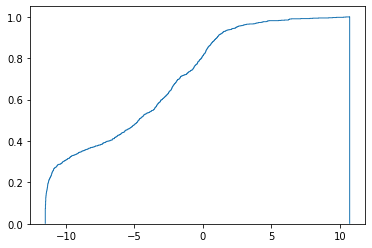

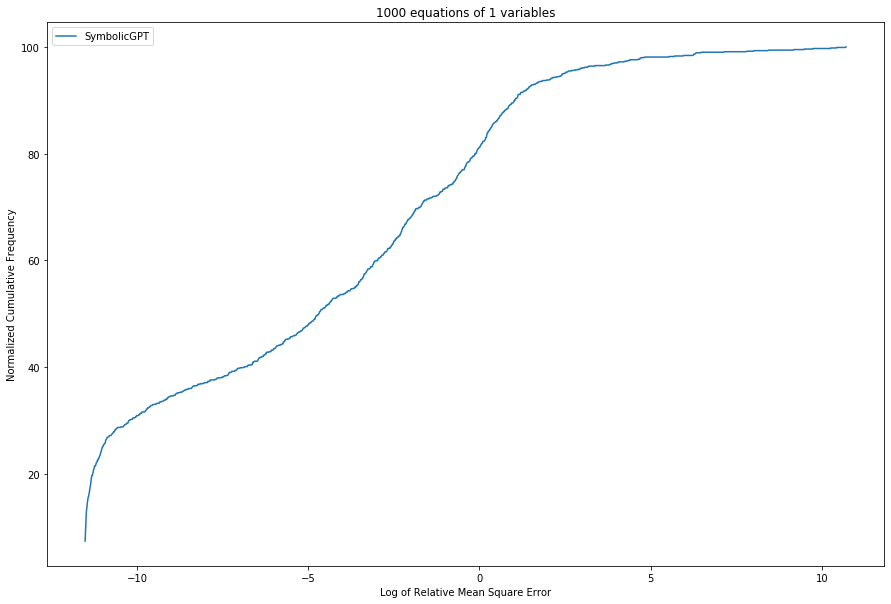

In [22]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName.split('.txt')[0])
plt.savefig(name)

In [21]:
# benchmarks